### Intro

음성 신호에 대한 기본적인 내용과 `torchaudio`를 사용하여 spectogram과 melspectrogram feature를 만드는 과정

[참고자료]
- https://ahnjg.tistory.com/93
- https://paintycode.tistory.com/22

You need to install the audio file I/O backend.

[순서]
1. 의존성 패키지 설치
    - `brew install libsndfile`
    - `brew install sox`
2. `torchaudio`와 `soundfile` 설치

In [1]:
import torch
import torch.nn as nn
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import IPython
import numpy as np

In [2]:
torchaudio.list_audio_backends()

['soundfile']

In [3]:
print(torch.__version__)
print(torchaudio.__version__)

2.6.0
2.6.0


### Load Data

- 음성 파일(.wav)을 `torchaudio`로 읽어올 수 있음
- 음성 파일이란 일정한 시간 간격을 가지고 어떤 지점의 음압을 측정한 것을 의미
- 음성 파일에서 일정한 시간 간격으로 음압을 측정하는 주파수를 **sampling rate**이라고 함

torchaudio를 사용해 음성을 읽으면 음성 데이터와 sampling rate을 반환하고, 음성 데이터의 크기를 보면 [1, 661794]로 나와 있는데, 1은 채널의 개수(녹음한 마이크의 개수), 661794는 데이터의 길이를 의미한다.

그러므로 데이터의 길이를 sampling rate으로 나누어 주면 음성 파일의 시간을 알 수 있다.

In [4]:
file_path = './data/blues.00000.wav'

data, sampling_rate = torchaudio.load(file_path)

print(f"Data: {data}")
print(f"Data Shape: {data.shape}")
print(f"Sampling Rate: {sampling_rate}")
print(f"Audio Duration: {data.size(1) / sampling_rate} seconds")

Data: tensor([[ 0.0073,  0.0166,  0.0076,  ..., -0.0556, -0.0611, -0.0642]])
Data Shape: torch.Size([1, 661794])
Sampling Rate: 22050
Audio Duration: 30.013333333333332 seconds


In [5]:
IPython.display.Audio(data, rate=sampling_rate)

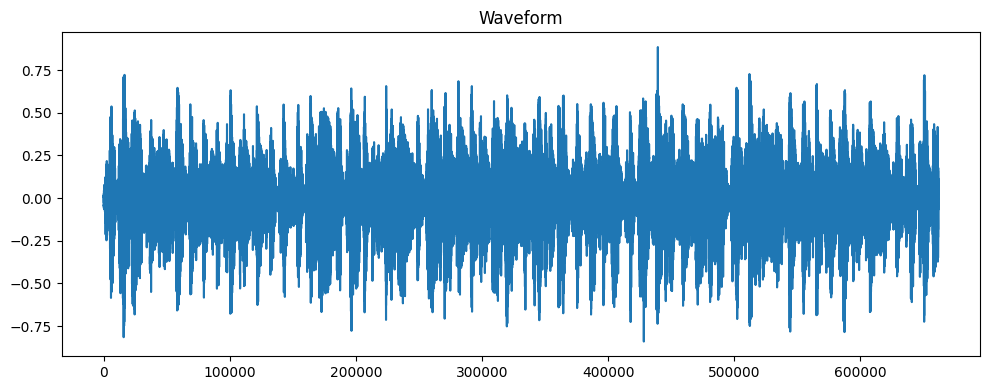

In [9]:
# Visualisation the waveform

figure, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(data[0, :])
ax.title.set_text('Waveform')
figure.tight_layout()

### Spectrogram, Melspectrogram 변환

#### 푸리에 변환
- 음성 신호에 푸리에 변환을 적용하면 각 진동수 성분이 그 음성에 얼마나 들어있는지 구할 수 있다.
- 즉, 음성 신호에 저음이 얼마나 있고, 고음이 얼마나 있는지를 정량적으로 구할 수 있다.

#### STFT (Short Term Fourier Transform)
- 음성을 작은 단위로 잘라서(0.01초 수준) 각 조각에 푸리에 변환을 적용할 수 있다.
- 이것을 STFT이라고 부르고, 일반적으로 이 결과의 L2 norm을 spectrogram이라고 한다.

- 음성 신호는 시간에 따라 계속 변하는 non-stationary 신호이다.
- 따라서, 전체 신호에 대해 한 번에 Fourier Transform을 적용하는 것보다, 짧은 시간 간격(window)로 나누어 각 구간에 대해 푸리에 변환을 수행하는 것이 효과적이다.

#### Melspectogram
- Melspectrogram은 spectrogram에 mel-filter라는 필터를 적용하여 얻어진다.
- Melspectrogram은 사람의 청각 기관이 저음에서 주파수 변화에 민감하고 고음에서는 주파수의 변화에 덜 민감한 특징을 반영한다.
- **즉, 사람이 잘 인식하는 주파수에 가중치를 준다.**
- 음성처리에서는 주로 melspectrogram을 사용하며, melspectrogram은 spectrogram보다 크기가 작아 학습 속도 면에서도 유리하다.

### Torchaudio의 `transforms` 함수

`torchaudio`에서는 다음과 같이 spectrogram과 melspectrogram을 얻을 수 있는 프로세스를 정의할 수 있다.
AmplitudeToDB는 power 단위의 spectrogram 또는 melspectrogram을 dB(로그) 단위로 변경해준다.



1. `n_fft`
- FFT(Fast Fourier Transform)은 이산 푸리에 변환(Discrete Fourier Transform, DFT)을 빠르게 계산하는 알고리즘인데, `n_fft`는 이 FFT의 크기(size)를 결정한다.
- 즉, 한 번에 처리할 샘플의 개수를 나타낸다. 
- 값이 클수록 주파수의 해상도가 높아지지만, 시간 해상도가 낮아진다.
- 값이 작을수록 시간 해상도가 높아지지만 주파수 해상도는 낮아진다.
- `n_fft // 2 + 1`개의 조각들(bin)을 생성한다.
- 일반적으로 2의 거듭제곱으로 설정한다.

2. `win_length`
- STFT을 수행할 때, 음성 신호를 짧은 구간으로 나누는데, 이 구간의 길이를 `win_length`라고 한다.
- `n_fft`보다 작거나 같아야 한다.
- 만약 `win_length`가 `n_fft`보다 작으면, 나머지 부분은 0으로 채워진다(padding).
- `win_length`가 길수록 주파수 해상도가 높아지고, 짧을수록 시간 해상도가 높아진다.
- 자연어 처리 분야에서는 25ms의 크기를 기본으로 하고 있으며, 16000Hz인 음성에서는 400에 해당하는 값이다. (16000/40)

3. `hop_length`
- STFT를 수행할 때, 윈도우를 얼마나 이동시킬지 결정하는 파라미터
- `hop_length`가 작을수록 윈도우가 촘촘하게 겹치게 되어 시간 해상도가 높아지고, `hop_length`가 클수록 윈도우가 덜 겹치게 되어 시간 해상도가 낮아진다.
- 일반적으로 10ms의 크기를 기본으로 하고 있으며, 16000Hz인 음성에서는 160에 해당하는 값
- **자연스러운 spectrogram을 위해 몇 개의 sample을 겹치게 할 것인지** (default: `win_length // 2`)

4. `n_mel`
- 적용할 mel filter의 개수

In [21]:
n_fft = int(np.ceil(0.025 * sampling_rate))
win_length = int(np.ceil(0.025 * sampling_rate))
hop_length = int(np.ceil(0.01 * sampling_rate))
n_mels = 80

spectrogram = nn.Sequential(
    T.Spectrogram(
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
    ),
    T.AmplitudeToDB()
)

mel_spectrogram = nn.Sequential(
    T.MelSpectrogram(
        sample_rate=sampling_rate,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        n_mels=n_mels,
    ),
    T.AmplitudeToDB()
)

In [22]:
spec = spectrogram(data)
mel_spec = mel_spectrogram(data)

print(f"Spectrogram shape:{spec.shape}")
print(f"Mel-spectrogram shape:{mel_spec.shape}")



Spectrogram shape:torch.Size([1, 257, 4137])
Mel-spectrogram shape:torch.Size([1, 80, 4137])


각각의 크기는 채널을 무시하면 [277, 2995], [80, 2995]인데, 2995는 시간축 방향 성분 수, 277과 80은 주파수 방향 성분 수를 의미한다.

Melspectrogram의 주파수 방향 성분 수가 80인 이유는 n_mels가 80이었기 때문이다.

Spectrogram의 경우 $n_{fft}/2 + 1$개의 주파수 방향 성분이 얻어지게 된다.


In [23]:
print(spec[0])

tensor([[  12.2716,    4.4927,    6.1334,  ...,   13.8767,   20.8302,
           17.2142],
        [   8.4305,    6.0924,    5.8527,  ...,   15.5283,   20.0886,
           14.9398],
        [ -20.3385,    4.5948,    4.2318,  ...,   17.3857,   17.5867,
           20.3251],
        ...,
        [ -41.4710,  -61.8714,  -94.8259,  ...,  -81.3729,  -79.8709,
          -37.9779],
        [ -41.6151,  -61.0410,  -82.8915,  ...,  -77.3590,  -81.8888,
          -37.9126],
        [ -41.6953,  -64.8725,  -80.3256,  ...,  -76.2083, -100.0000,
          -37.8983]])


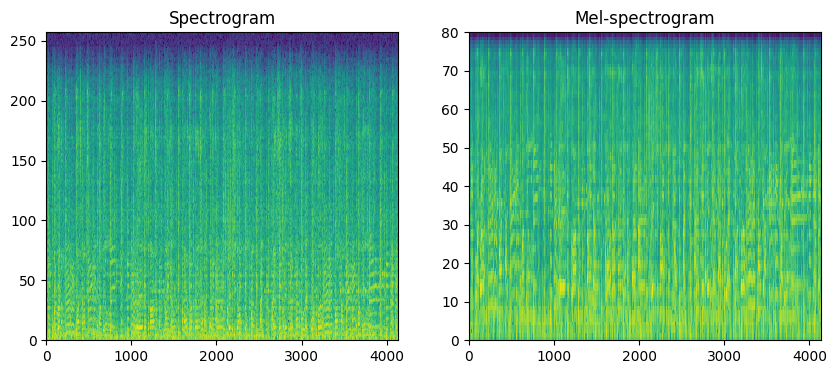

In [24]:
figure, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].pcolor(spec[0])
ax[0].set_title("Spectrogram")
ax[1].pcolor(mel_spec[0])
ax[1].set_title("Mel-spectrogram")
plt.show()

`win_length`가 커질수록 주파수 성분에 대한 해상력은 높아지지만(정밀해진다), 시간 성분에 대한 해상력은 낮아지게 된다.

즉, 더 정밀한 주파수 분포를 얻을 수 있으나, 시간에 대한 주파수 변화를 관찰하기 어려워진다.

`n_fft`의 크기를 키우면 주파수 성분의 수는 증가할지 몰라도, 실제 주파수의 해상력은 증가하지 않는다.

`matplotlib.pyplot`의 `specgram`을 사용하여 간편하게 spectrogram을 시각화할 수 있다.

In [10]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    # waveform = waveform.numpy()

    figure, ax = plt.subplots()
    ax.specgram(waveform[0, :], Fs=sample_rate)
    figure.suptitle(title)
    figure.tight_layout()

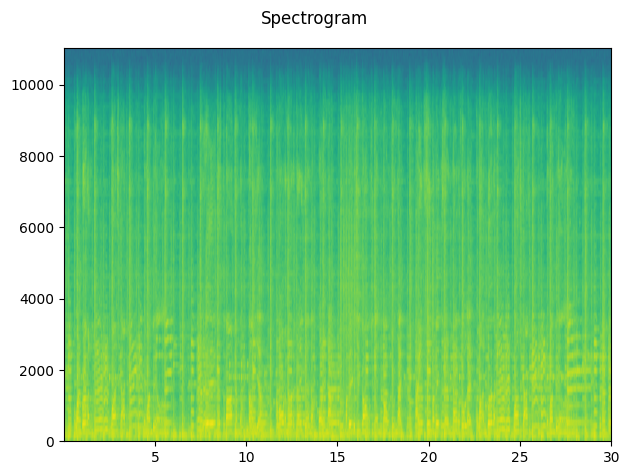

In [11]:
plot_specgram(data, sampling_rate)